# Parte 1. Análisis Exploratorio

El objetivo de este Notebook es realizar un análisis descriptivo de los productos que tienen descuento. Se comenzará con una exploración inicial de los datos, y se plantearán preguntas a medida que se vaya descubriendo información. 

Se descargó información de hasta 10.000 productos por cada una de las 31 categorías en Colombia al 24 de diciembre de 2020 (sujeto a la disponibilidad de información en el Marketplace). Se requirió hacer tal extracción debido a que en una extracción inicial de 1.000 productos por categoría se obtuvo apenas 1800 productos con descuento (apenas el 5.6% de los productos). Se espera tener una mayor cantidad de información para analizar.

- ¿Qué relación hay entre el precio original de un producto y el descuento que se le aplica?
- ¿Qué tipo de productos reciben más descuentos?
- ¿Qué tanto influye la antigüedad de un producto en la aplicación de un descuento? 
- ¿Existe alguna relación entre la reputación de los vendedores y los descuentos que se aplican a sus productos?
- ¿Hay más descuentos en los productos que tienen envío gratis?
- ¿Productos nuevos reciben más descuentos?
- Las tiendas oficiales tienen más descuentos?

Algunas conclusiones podrían estar sesgadas debido a la temporada navideña, por lo que sería importante repetir el análisis posteriormente.

## Carga de Datos

In [1]:
import os
import seaborn as sns
import  matplotlib.pyplot as plt
import pandas as pd

sns.set(rc={'figure.figsize':(10, 5)})

In [2]:
data_folder = '../data'
data_by_category = [pd.read_csv(os.path.join(data_folder, file), sep = ";") for file in os.listdir('../data') if file.find('.csv') != -1]
complete_df = pd.concat(data_by_category, axis = 0, ignore_index=True)
complete_df['has_discount'] = ~complete_df.original_price.isnull()

In [16]:
complete_df.columns

Index(['id', 'title', 'price', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'condition', 'accepts_mercadopago',
       'original_price', 'category_id', 'seller_level_id',
       'seller_powerseller', 'positive_rating', 'negative_rating',
       'neutral_rating', 'free_shipping', 'store_pickup', 'number_of_tags',
       'is_official_store', 'month_update', 'year_update', 'year_created',
       'month_created', 'total_questions', 'category_name', 'has_discount'],
      dtype='object')

In [4]:
n_observations = len(complete_df)
category_counts = complete_df.category_name.value_counts()/n_observations * 100
print(f'Se registraron {n_observations} para {len(category_counts)} categorías dentro de la búsqueda.')

Se registraron 271082 para 31 categorías dentro de la búsqueda.


La siguiente figura muestra la proporción de productos con descuento dentro de cada categoría. De esta gráfica se puede concluir que:
- No todas las categorías de productos cuentan con descuento 
- La proporción de productos con descuento no supera el 15% en cada categoría. 

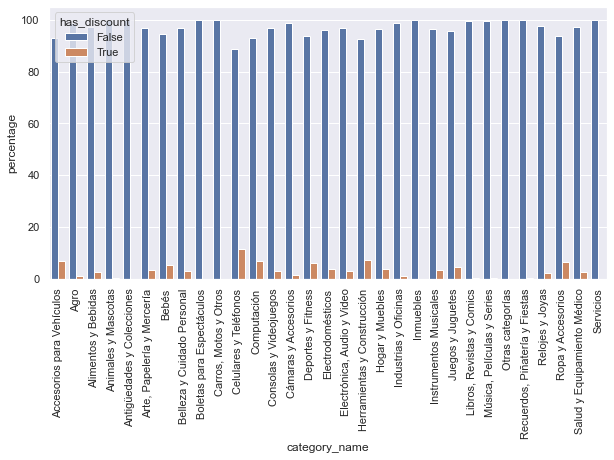

In [5]:
category_counts = (complete_df.groupby(['category_name'])['has_discount']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('category_name'))

p = sns.barplot(x="category_name", y="percentage", hue="has_discount", data=category_counts)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels

### Selección de Productos con Descuento

Se identifica los productos con descuento como aquellos cuyo *original_price* no es nulo. La tabla de frecuencias muestra que hay algunas categorías de productos que si bien cuentan con descuento, apenas tienen representación. Por esta razón, se decide eliminar las categorías de productos que cuentan con menos de 50 productos con descuento. 
De esta forma, se van a explorar los productos de 21 categorías. 

In [6]:
products_with_discount = complete_df[complete_df.has_discount]

In [7]:
count_of_discount = products_with_discount.category_name.value_counts()
count_of_discount

Celulares y Teléfonos             1138
Herramientas y Construcción        725
Accesorios para Vehículos          707
Computación                        680
Deportes y Fitness                 612
Bebés                              544
Juegos y Juguetes                  443
Electrodomésticos                  385
Hogar y Muebles                    366
Instrumentos Musicales             341
Arte, Papelería y Mercería         329
Belleza y Cuidado Personal         314
Consolas y Videojuegos             307
Electrónica, Audio y Video         302
Alimentos y Bebidas                266
Relojes y Joyas                    240
Ropa y Accesorios                  218
Cámaras y Accesorios               126
Industrias y Oficinas              125
Salud y Equipamiento Médico         94
Agro                                89
Música, Películas y Series          43
Libros, Revistas y Comics           26
Animales y Mascotas                 18
Recuerdos, Piñatería y Fiestas      15
Antigüedades y Coleccione

In [8]:
products_with_discount = products_with_discount[products_with_discount.category_name.isin(count_of_discount[count_of_discount >= 50].index)]

### Cálculo del Descuento

Se calculará el descuento de cada producto teniendo en cuenta que, 

$$original\_price_i \times (1 - d_i) = price_i$$


donde $original\_price_i$ es el precio original del $i$-ésimo producto, $d_i$ es el descuento que tiene y $price_i$ es el precio final del producto. 


Despejando se tiene que, 

$$d_i = 1 - \frac{price_i}{original\_price_i}$$

In [9]:
products_with_discount['vlr_descuento'] = 1 - products_with_discount['price']/products_with_discount['original_price']

In [10]:
products_with_discount['vlr_descuento'].describe()

count    8351.000000
mean        0.259277
std         0.136282
min         0.000000
25%         0.166945
50%         0.231951
75%         0.333333
max         0.820821
Name: vlr_descuento, dtype: float64

De las medidas de tendencia central calculadas para el valor de descuento se puede observar que la mayoría de los productos (el 75%) tiene descuentos de hasta 1/3 del valor original del producto. Adicionalmente, se puede notar que hay productos con descuento 0%, identificando un problema en el API. 

Los casos de descuento 0% fueron verificados dentro de la API, y aunque su *original_price* no es nulo, dentro del Marketplace no se muestra ningun bug visual. A continuación se deja un ejemplo de un producto: [Respuesta API](https://api.mercadolibre.com/items/MCO458621492), [Producto en Marketplace](https://articulo.mercadolibre.com.co/MCO-458621492-alfombra-tapete-negro-gris-de-sala-120-x-170cms-mitapete-_JM). Adicionalmente, se encontraron productos cuyo descuento es inferior al 1% y aprecen en el Marketplace [como esta batidora.](https://articulo.mercadolibre.com.co/MCO-451469806-batidora-de-mano-oster-_JM)

In [11]:
products_with_discount = products_with_discount[products_with_discount.vlr_descuento >= 0.01]

### Relación Descuentos con Categorías y Precios

En este primer análisis se ivestiga la relación por categoría entre el descuento aplicado a un producto y su precio original. 

A continuación se presenta un Boxplot del valor de descuento en cada categotía. Se identifica que los instrumentos musicales, Agro y los accesorios para vehículos presentan menores niveles de descuento en general. En contraste, la categoría de Relojería y Joyas tiene los mayores niveles de descuento. El resto de categorías presentan una distribución de descuentos más o menos estable y similar.

Esto podría estar relacionado con que los productos más caros presentan mayores descuentos para facilitar su compra. Para verificar esta hipótesis se deben analizar los precios originales de los productos.

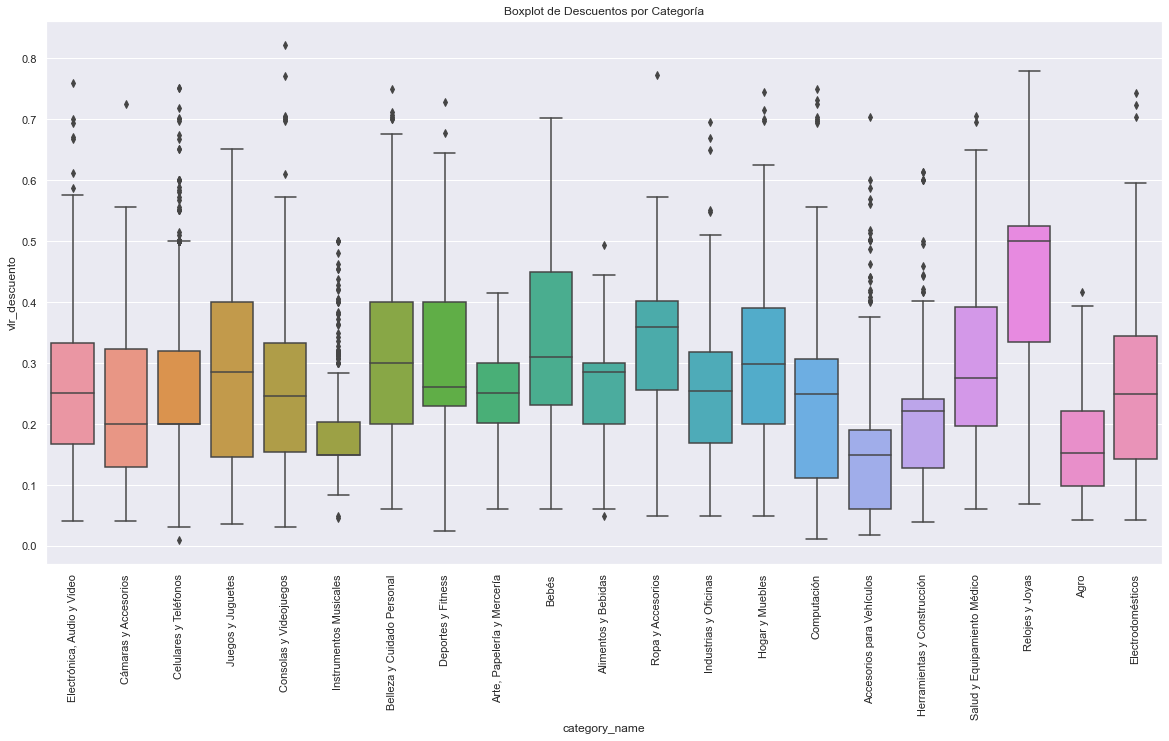

In [23]:
plt.figure(figsize = (20, 10))
ax = sns.boxplot(x="category_name", y="vlr_descuento", data=products_with_discount)
plt.title('Boxplot de Descuentos por Categoría')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

En la siguiente figura se muestra un boxplot de los precios originales de los productos. Con este gráfico se observa que la hipótesis no es necesariamente cierta, pues las categorías con distribución de descuentos disímiles al resto (i.e. "Agro", "Relojes y Joyería", "Computadores y Videojuegos" y "Accesorios para Vehículos") presentan los precios originales más altos.

(0.0, 3000000.0)

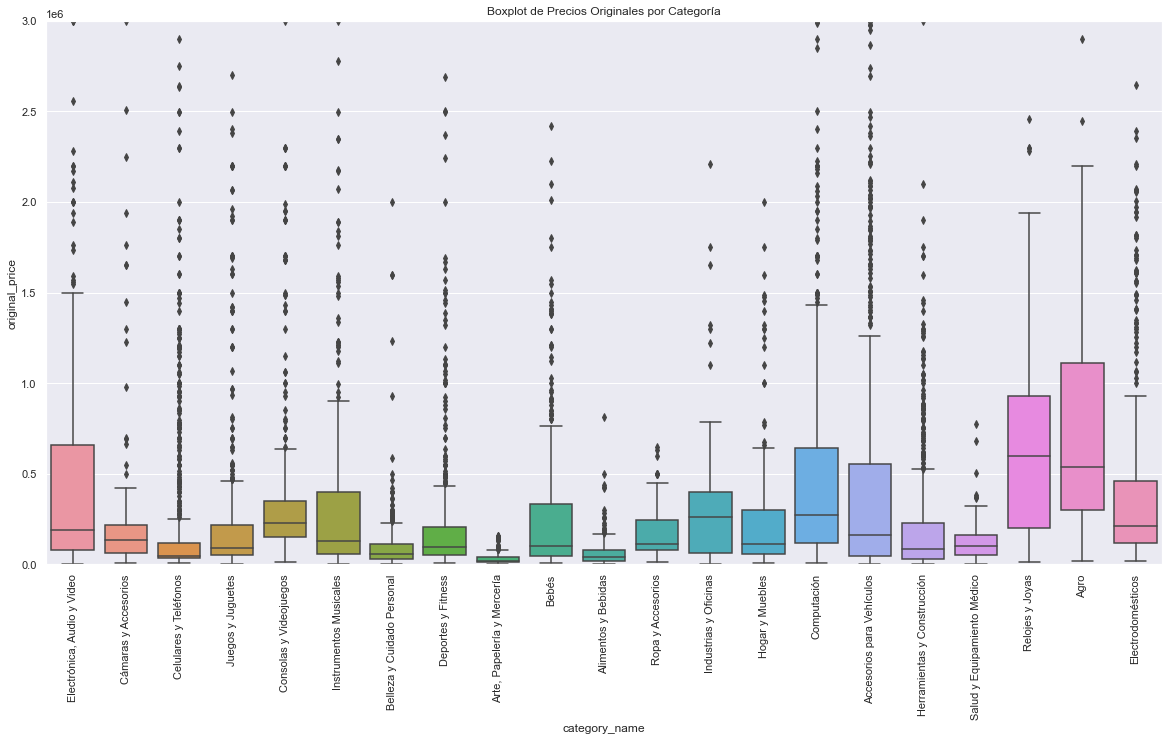

In [24]:
plt.figure(figsize = (20, 10))
ax = sns.boxplot(x="category_name", y="original_price", data=products_with_discount)
plt.title('Boxplot de Precios Originales por Categoría')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim((0, 3e6))

**Conclusión:** No necesariamente hay una relación directa entre el precio de los productos y su descuento. Sin embargo, sí existe una diferencia entre los niveles de descuento por categoría. De forma tal que los productos de joyería reciben mayores niveles de descuento (potencialmente por temas de temporada), mientras que gaming, agro y accesorios para vehículos reciben los menores niveles.

## Antigüedad y Descuentos

El interés de esta sección es determinar si existe una relación entre la antigüedad de un producto y los descuentos que se le aplican. Se plantea como hipótesis que los productos más antiguos tienen mayores niveles de descuento que los más recientes.

El API de Mercado Libre no reporta la fecha de publicación de los productos que se encuentran disponibles, y estos tampoco aparecen de manera pública dentro del Marketplace. De esta forma, se genera un proxy de la antigüedad de un producto basado en la fecha de publicación de la primera pregunta que se le hizo. De esta forma, la antigüedad de un producto es *no menor* a la antigüedad de la primera pregunta. 

$$y^*_{i} \geq y_{pregunta}$$

Donde $y^*_{i}$ es la antiguedad real del $i$-ésimo producto y $y_{pregunta}$ es la antiguedad de la primera pregunta. 

Es importante resaltar que este análisis se realizará con los productos que tienen al menos una pregunta, que corresponden al 93% de la muestra de productos con descuento. 

In [35]:
n_products_with_date = (~products_with_discount.year_created.isnull()).sum()
print("Cantidad de Productos con al menos una pregunta: {:.0%}".format(n_products_with_date/len(products_with_discount)))

Cantidad de Productos con al menos una pregunta: 93%


0.9309352517985612

In [ ]:
round